# Imports

In [51]:
import pandas as pd, numpy as np
from numpy import random
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
from tqdm.notebook import tqdm

In [44]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error

In [2]:
import plotly.express as px

In [20]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import arma_order_select_ic

# Helper Functions

In [15]:
def ad_fuller(timeseries):
    print ('Dickey-Fuller Test indicates:')
    df_test = adfuller(timeseries, regression='ct', autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(output)

## BTC Data

In [3]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
path_raw_data = Path() / '..' / '..' / 'token_labs_python' / 'data' / 'raw'

In [4]:
df_ohlc_1d_raw = pd.read_csv(path_raw_data / 'ohlc_1d_binance_bybit_swaps.csv')
df_btc_1d = (
    df_ohlc_1d_raw
    .assign(datetime = lambda x: pd.to_datetime(x['datetime']))
    .query('exchange == "binance" and instrument == "BTCUSDT"')
    .assign(range = lambda x: x['high'] - x['low'])
    .assign(range_perc = lambda x: x['range'] / x['open'])
    .assign(log_return = lambda x: np.log(x['close']).diff())
    .sort_values('datetime')
)

<Axes: xlabel='datetime'>

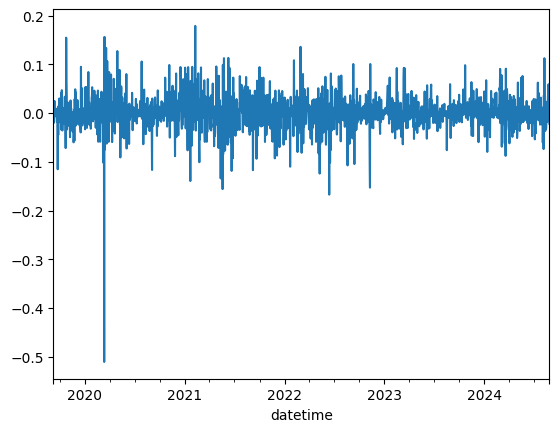

In [27]:
(
    df_btc_1d
    .set_index('datetime')
    ['log_return']
    # .ewm(span=30)
    # .mean()
    .plot()
)

<Axes: xlabel='datetime'>

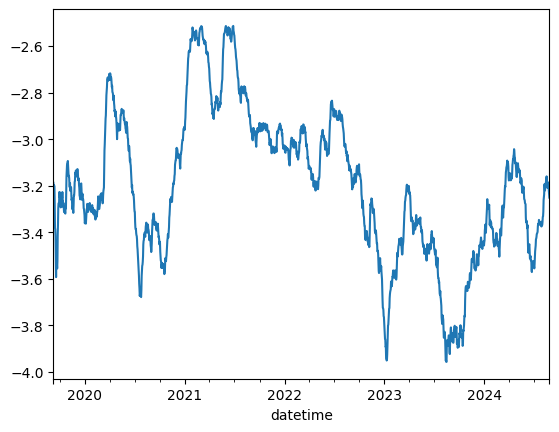

In [33]:
(
    np.log(
        df_btc_1d
        .set_index('datetime')
        # ['log_range']
        ['range_perc']
        # .ewm(span=30)
        # .mean()
        
    )
    .ewm(span=60)
    .mean()
    .plot()
)

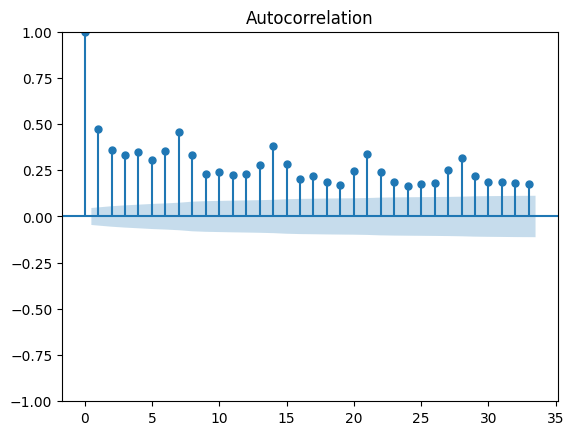

In [6]:
plot_acf(
    np.log(
        df_btc_1d['range_perc']
        .dropna()
        .values
    ),
    bartlett_confint=True
);

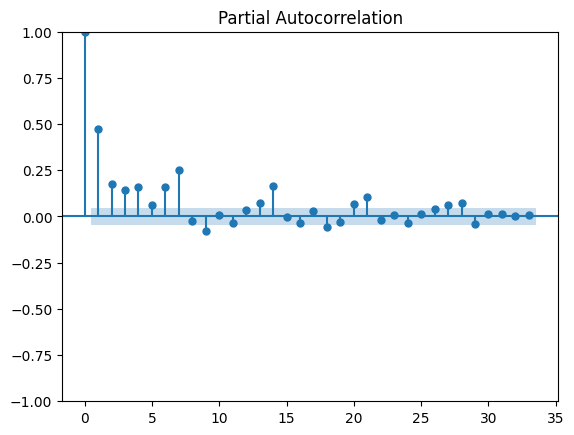

In [7]:
plot_pacf(
    np.log(
        df_btc_1d['range_perc']
        .dropna()
        .values
    ),
);

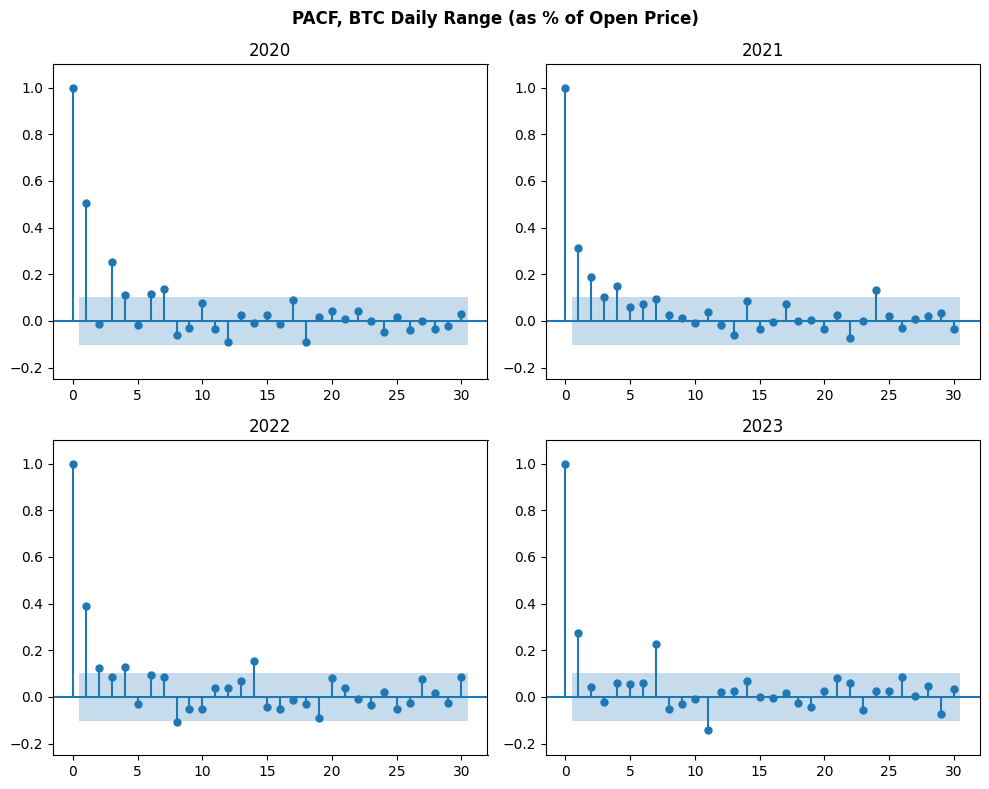

In [8]:
# Create a 2x2 grid of plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ranges_2020 = df_btc_1d.set_index('datetime').loc['2020', 'range_perc'].dropna()
ranges_2021 = df_btc_1d.set_index('datetime').loc['2021', 'range_perc'].dropna()
ranges_2022 = df_btc_1d.set_index('datetime').loc['2022', 'range_perc'].dropna()
ranges_2023 = df_btc_1d.set_index('datetime').loc['2023', 'range_perc'].dropna()

# Plot ACF for each dataset in the grid
plot_pacf(ranges_2020, ax=axes[0, 0], lags=30)#, bartlett_confint=False)
axes[0, 0].set_title('2020')
axes[0, 0].set_ylim(-0.25, 1.1)

plot_pacf(ranges_2021, ax=axes[0, 1], lags=30)#, bartlett_confint=False)
axes[0, 1].set_title('2021')
axes[0, 1].set_ylim(-0.25, 1.1)

plot_pacf(ranges_2022, ax=axes[1, 0], lags=30)#, bartlett_confint=False)
axes[1, 0].set_title('2022')
axes[1, 0].set_ylim(-0.25, 1.1)

plot_pacf(ranges_2023, ax=axes[1, 1], lags=30)#, bartlett_confint=False)
axes[1, 1].set_title('2023')
axes[1, 1].set_ylim(-0.25, 1.1)

plt.suptitle('PACF, BTC Daily Range (as % of Open Price)', fontweight='bold')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.savefig('BTC_PACF_by_year', dpi=300)
plt.show()

# Fit Model

In [41]:
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

In [42]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

In [11]:
log_ranges = np.log(
    df_btc_1d
    .set_index('datetime')
    ['range_perc']
    .dropna()
    .loc['2021']
)
seas = sm.tsa.seasonal_decompose(log_ranges, period=7)

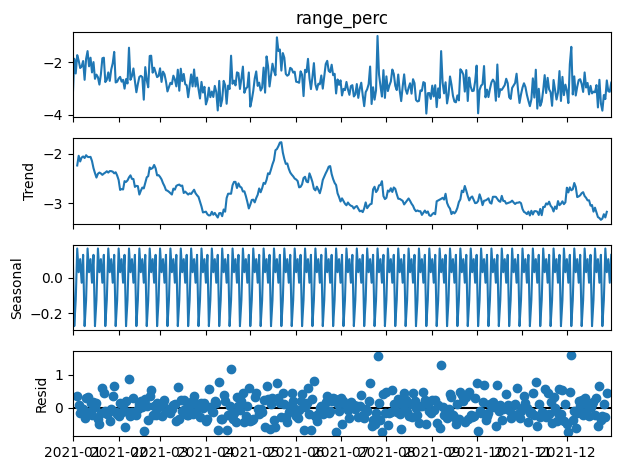

In [13]:
seas.plot();

In [ ]:
p = q = range(0, 7)
d = range(0, 2)

# Generate all different combinations of p, d, q triplets
pdq = list(itertools.product(p, d, q))

# Perform grid search to find the best parameters
best_aic = float("inf")
best_params = None

for param in pdq:
    try:
        model = ARIMA(data, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except:
        continue

print(f'Best ARIMA parameters: {best_params}')
print(f'Best AIC: {best_aic}')

# Step 3: Fit the Final ARIMA Model with the Best Parameters
model = ARIMA(data, order=best_params)
results = model.fit()

# Print the model summary
print(results.summary())

# Step 4: Model Diagnostics
residuals = results.resid
sm.graphics.tsa.plot_acf(residuals, lags=40)
sm.graphics.tsa.plot_pacf(residuals, lags=40)
sm.qqplot(residuals, line='s')
plt.show()

In [48]:
p = q = range(0, 7)
d = range(0, 2)

# Generate all different combinations of p, d, q triplets
pdq = list(itertools.product(p, d, q))

In [50]:
SARIMAX

98